# Data Analysis Process Overview
**The goal of this analysis** is to extract actionable insights from global air quality data to inform environmental policy and public health initiatives. By integrating data from various sources, including the OpenAQ API and world cities' geographic coordinates, we aim to identify patterns and correlations in air pollution levels. Through rigorous data collection, preprocessing, and exploratory data analysis (EDA), we seek to understand the distribution of common pollutants and their impact on air quality. The application of clustering algorithms will segment the data into meaningful groups, revealing the spatial distribution of air quality metrics. The final step involves creating an interactive visualization to disseminate our findings effectively, enabling stakeholders to explore the nuances of air quality on a global scale.
  

**NOTE:** This document outlines the comprehensive steps taken in the data analysis process, from initial data collection to the final user-interactive visualization.  
Click on any of the parts below to navigate to the corresponding section of the analysis.
***
**Part 1.** [Data Collection Setup and Execution](#Data-Collection-Setup-and-Execution)
   - Base URL and Parameters
   - Session and Retry Strategy
   - Data Collection Variables
   - Data Fetching Loop
   - Error Handling
   - Session Closure and Data Aggregation
   - Data Inspection and Export  
***    

**Part 2.** [Data Preprocessing and Spatial Join with External Data](#Data-Preprocessing-and-Spatial-Join-with-External-Data)
   - Loading and preparing `worldcities.csv`
   - Constructing a BallTree
   - Identifying and merging closest city information
***
**Part 3.** [Exploratory Data Analysis (EDA) Overview](##Exploratory-Data-Analysis-EDA-Overview)
   - Distribution Analysis
   - Data Quality Checks
   - Outlier Detection
   - Correlation Analysis
   - Aggregate Analysis for PM10
***
**Part 4.** [Data Preprocessing](#Data-Preprocessing)
   - Data Cleaning
   - Outlier Treatment
   - Normalization
   - Data Transformation
   - Handling Missing Values Post-Pivot
   - Scaling Pivot Table
***
**Part 5.** [Machine Learning: Clustering Analysis](#Machine-Learning-Clustering-Analysis)
   - `fit_clustering_models` function
   - Supported Models and Evaluation Metrics
   - Execution and Results
   - KMeans Labels Extraction
***
**Part 6.** [Preprocessing for User-Interactive Visualization](#Preprocessing-for-User-Interactive-Visualization)
   - Unique Key Generation
   - Merging Datasets
   - Preparing Data for Geographical Visualization
***
**Part 7.** [User-Interactive Visualization: Air Quality Map](#User-Interactive-Visualization-Air-Quality-Map)
   - Threshold Calculation Functions
   - Dynamic Threshold Calculation
   - Map Initialization with Folium
   - Marker Cluster Initialization
   - Color Assignment Function
   - Populating the Map with Data
   - Saving the Interactive Map
***
Please follow the links to jump to the respective sections for detailed analysis and insights.


In [2]:
# Importing libraries
# Data handling and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame

# Machine learning and clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import BallTree

# Geospatial data handling
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import MarkerCluster

# Network communication
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Miscellaneous utilities
import time
import os
import warnings

# Disable warnings in notebook
warnings.filterwarnings('ignore')

# Additional settings
plt.style.use('seaborn')  # Setting seaborn style for plots

***
# Data Collection Setup and Execution

- **Base URL and Parameters**: The base URL for the OpenAQ API (sourced from [OpenAQ](https://openaq.org/)) is set, and parameters for the API request are defined. Parameters include the limit of results per request, the initial page, the date range of data, and the country code.

- **Session and Retry Strategy**: A `requests` session is established with a retry strategy for robust network communication. The `Retry` object specifies the total number of retries, read and connect retries, backoff factor, and status codes that trigger a retry, enhancing the resilience of the API calls.

- **Data Collection Variables**: Variables are initialized for storing collected data, tracking the total number of records fetched, and managing request delay times.

- **Data Fetching Loop**: A loop is executed to continuously make paginated API requests. It parses and normalizes the JSON response, adds the data to a list, and handles pagination. Detailed logging is provided for monitoring progress.

- **Error Handling**: Within the loop, try-except blocks effectively manage request exceptions and other unexpected errors. The strategy involves error counting and adaptive request limiting to maintain steady data collection despite potential API rate limits or network issues.

- **Session Closure and Data Aggregation**: After data collection, the session is closed to free resources. All paginated data is then merged into a single DataFrame for further use.

- **Data Inspection and Export**: The DataFrame's head is displayed for a quick preview and its structure is examined. Finally, the collected dataset is exported to a CSV file, providing a local copy for analysis.
***

In [33]:
# Setting up the base URL and parameters for the API request
base_url = "https://api.openaq.org/v2/measurements"
params = {
    'limit': 1000,  # Maximum number of results to return per request
    'page': 1,  # Initial page of results
    'date_from': '2023-01-01T00:00:00+00:00',  # Start date for data
    'date_to': '2023-12-31T23:59:59+00:00',  # End date for data
    'country': 'US'  # Country code for the data
}

# Setting up a requests session with retries for robustness
session = requests.Session()
retries = Retry(
    total=3,  # Total retries
    read=2,  # Retries for read errors
    connect=2,  # Retries for connection errors
    backoff_factor=0.5,  # Backoff factor for retries
    status_forcelist=[429, 500, 502, 503, 504],  # HTTP statuses to retry on
)

# Applying the retry strategy to the session for HTTP and HTTPS requests
session.mount('https://', HTTPAdapter(max_retries=retries))

# Initializing variables for data collection process
data_list = []  # List to store fetched data
total_records_fetched = 0  # Counter for total records fetched
request_delay = 1.0  # Delay between requests in seconds
max_limit = params['limit']  # Max number of records per request (configurable)
min_limit = 100  # Minimum number of records per request (configurable)
max_consecutive_errors = 3  # Maximum allowed consecutive errors
consecutive_errors = 0  # Current count of consecutive errors

# Data fetching loop
while True:
    try:
        # Making the API request
        response = session.get(base_url, params=params, timeout=5)
        response.raise_for_status()  # Raises error for bad status codes
        json_response = response.json()  # Parsing JSON response

        # Normalizing JSON data to flat table
        page_data = pd.json_normalize(json_response['results'])
        if page_data.empty:
            print("No more data to fetch.")
            break

        # Appending the data of the current page to the list
        data_list.append(page_data)
        total_records_fetched += len(page_data)  # Updating record counter

        # Logging progress
        print(f"Fetched {len(page_data)} records on page {params['page']} with limit {params['limit']}")

        params['page'] += 1  # Incrementing page parameter for next request
        consecutive_errors = 0  # Resetting consecutive errors counter on success

        time.sleep(request_delay)  # Sleeping for set delay

    except requests.exceptions.RequestException as e:
        # Handling request exceptions
        print(f"Request failed: {e}")
        consecutive_errors += 1  # Incrementing consecutive errors counter
        if consecutive_errors >= max_consecutive_errors:
            print("Maximum consecutive errors reached, stopping data collection.")
            break
        if params['limit'] > min_limit:
            params['limit'] //= 2
        print(f"Reducing limit to: {params['limit']} and retrying.")

        time.sleep(request_delay * 2)  # Sleeping for longer delay before retry

    except Exception as e:
        # Handling other exceptions
        print(f"An unexpected error occurred: {e}")
        break

# Closing the session
session.close()

# Concatenating all fetched data into a single DataFrame
all_data = pd.concat(data_list, ignore_index=True)

# Displaying the head of the DataFrame and total records fetched
print(all_data.head())
print(f"Total records fetched: {total_records_fetched}")

# Saving the data to a CSV file
all_data.to_csv(r"C:\Users\jangj\OneDrive\Juhyeon\01_School_GATECH\air_quality_data.csv", index=False)


Fetched 1000 records on page 1 with limit 1000
Fetched 1000 records on page 2 with limit 1000
Fetched 1000 records on page 3 with limit 1000
Request failed: HTTPSConnectionPool(host='api.openaq.org', port=443): Max retries exceeded with url: /v2/measurements?limit=1000&page=4&date_from=2023-01-01T00%3A00%3A00%2B00%3A00&date_to=2023-12-31T23%3A59%3A59%2B00%3A00&country=US (Caused by ReadTimeoutError("HTTPSConnectionPool(host='api.openaq.org', port=443): Read timed out. (read timeout=5)"))
Reducing limit to: 500 and retrying.
Fetched 500 records on page 4 with limit 500
Fetched 500 records on page 5 with limit 500
Fetched 500 records on page 6 with limit 500
Request failed: HTTPSConnectionPool(host='api.openaq.org', port=443): Max retries exceeded with url: /v2/measurements?limit=500&page=7&date_from=2023-01-01T00%3A00%3A00%2B00%3A00&date_to=2023-12-31T23%3A59%3A59%2B00%3A00&country=US (Caused by ReadTimeoutError("HTTPSConnectionPool(host='api.openaq.org', port=443): Read timed out. (rea

In [34]:
# Creates a copy of the DataFrame
all_data_copy = all_data.copy()
print(all_data.head())
print(all_data.shape)

   locationId                 location parameter  value           unit  \
0      384748                    WMHS1     um003   9.74  particles/cm³   
1      219518      The Madison Outside     um003   2.13  particles/cm³   
2       62468          tactrix rooftop     um003   3.08  particles/cm³   
3      923365       Lanai RD ES (4764)       pm1   0.00          µg/m³   
4      290502  1948 - Lowman Sp Ed Ctr      pm25   4.67          µg/m³   

  country  city  isMobile isAnalysis                  entity       sensorType  \
0      US  None     False       None  Community Organization  low-cost sensor   
1      US  None     False       None  Community Organization  low-cost sensor   
2      US  None     False       None  Community Organization  low-cost sensor   
3      US  None     False       None  Community Organization  low-cost sensor   
4      US  None     False       None  Community Organization  low-cost sensor   

                    date.utc                 date.local  coordinates

***
# Data Preprocessing and Spatial Join with External Data

- Load the [`worldcities.csv`](https://simplemaps.com/data/world-cities) file and convert latitude and longitude to radians for both air quality and world cities datasets.
- Construct a BallTree with world cities coordinates for efficient spatial querying.
- Identify the closest city from the world cities dataset for each point in the air quality dataset using the BallTree.
- Merge air quality data with the nearest city information into a new dataframe.
***

In [35]:
# Load the worldcities data
worldcities_data = pd.read_csv('worldcities.csv')

# Convert latitude and longitude
air_quality_coords = np.radians(all_data_copy[['coordinates.latitude', 'coordinates.longitude']])
worldcities_coords = np.radians(worldcities_data[['lat', 'lng']])

# Create a BallTree for the worldcities dataset
tree = BallTree(worldcities_coords, metric='haversine')

# Query the BallTree
distances, indices = tree.query(air_quality_coords, k=1)

# Make a copy of dataset
merged_data_with_city = all_data_copy.copy()

# Add the closest city information
for column in worldcities_data.columns:
    merged_data_with_city[column + '_worldcity'] = worldcities_data.iloc[indices.flatten()][column].values

merged_data_with_city.to_csv(r"C:\Users\jangj\OneDrive\Juhyeon\01_School_GATECH\merged_data_with_city.csv", index=False)

In [8]:
air_quality_data = pd.read_csv("merged_data_with_city.csv")
air_quality_data.rename(columns={'admin_name_worldcity': 'new_state', 'city_ascii_worldcity': 'new_city'}, inplace=True)

In [9]:
air_quality_data.head()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,...,new_city,lat_worldcity,lng_worldcity,country_worldcity,iso2_worldcity,iso3_worldcity,new_state,capital_worldcity,population_worldcity,id_worldcity
0,67784,Diamond St.,temperature,64.625000,f,US,NaN,False,NaN,Community Organization,...,San Francisco,37.7558,-122.4449,United States,US,USA,California,NaN,3290197,1840021543
1,67784,Diamond St.,pressure,1002.707500,mb,US,NaN,False,NaN,Community Organization,...,San Francisco,37.7558,-122.4449,United States,US,USA,California,NaN,3290197,1840021543
2,67784,Diamond St.,humidity,100.000000,%,US,NaN,False,NaN,Community Organization,...,San Francisco,37.7558,-122.4449,United States,US,USA,California,NaN,3290197,1840021543
3,1794834,West Point Elementary,pressure,868.780741,mb,US,NaN,False,NaN,Person,...,West Point,41.1220,-112.0995,United States,US,USA,Utah,NaN,10963,1840021354
4,1794834,West Point Elementary,pm1,14.337037,µg/m³,US,NaN,False,NaN,Person,...,West Point,41.1220,-112.0995,United States,US,USA,Utah,NaN,10963,1840021354


In [10]:
air_quality_data.shape

(8050, 26)

***
<a id='#Exploratory-Data-Analysis-EDA-Overview'></a>
# Exploratory Data Analysis (EDA) Overview

In this section, we delve into the Exploratory Data Analysis (EDA) of air quality data. The main objectives are:

1. **Distribution Analysis:** Understanding the distribution of various air quality parameters to gain insights into their spread and central tendencies.

2. **Data Quality Checks:** Assessing the dataset for missing values and other irregularities that might impact the analysis.

3. **Outlier Detection:** Identifying and visualizing outliers in the data, particularly for common pollutants. This helps in understanding extreme values and their impact on the overall data quality.

4. **Correlation Analysis:** Exploring the relationships between different air quality parameters to identify patterns and correlations.

5. **Aggregate Analysis for PM10:** Focusing on a common air pollutant, PM10, this step involves aggregating the data at the city level to understand which cities have the highest average PM10 values.
***

***
#### Distribution Analysis of Air Quality Parameters

- Define a function for layout calculation in subplots.
- Identify unique air quality parameters.
- Create subplots for each parameter to visualize their distribution using histograms.
- Use seaborn's `histplot` for a combined histogram and KDE plot.
***

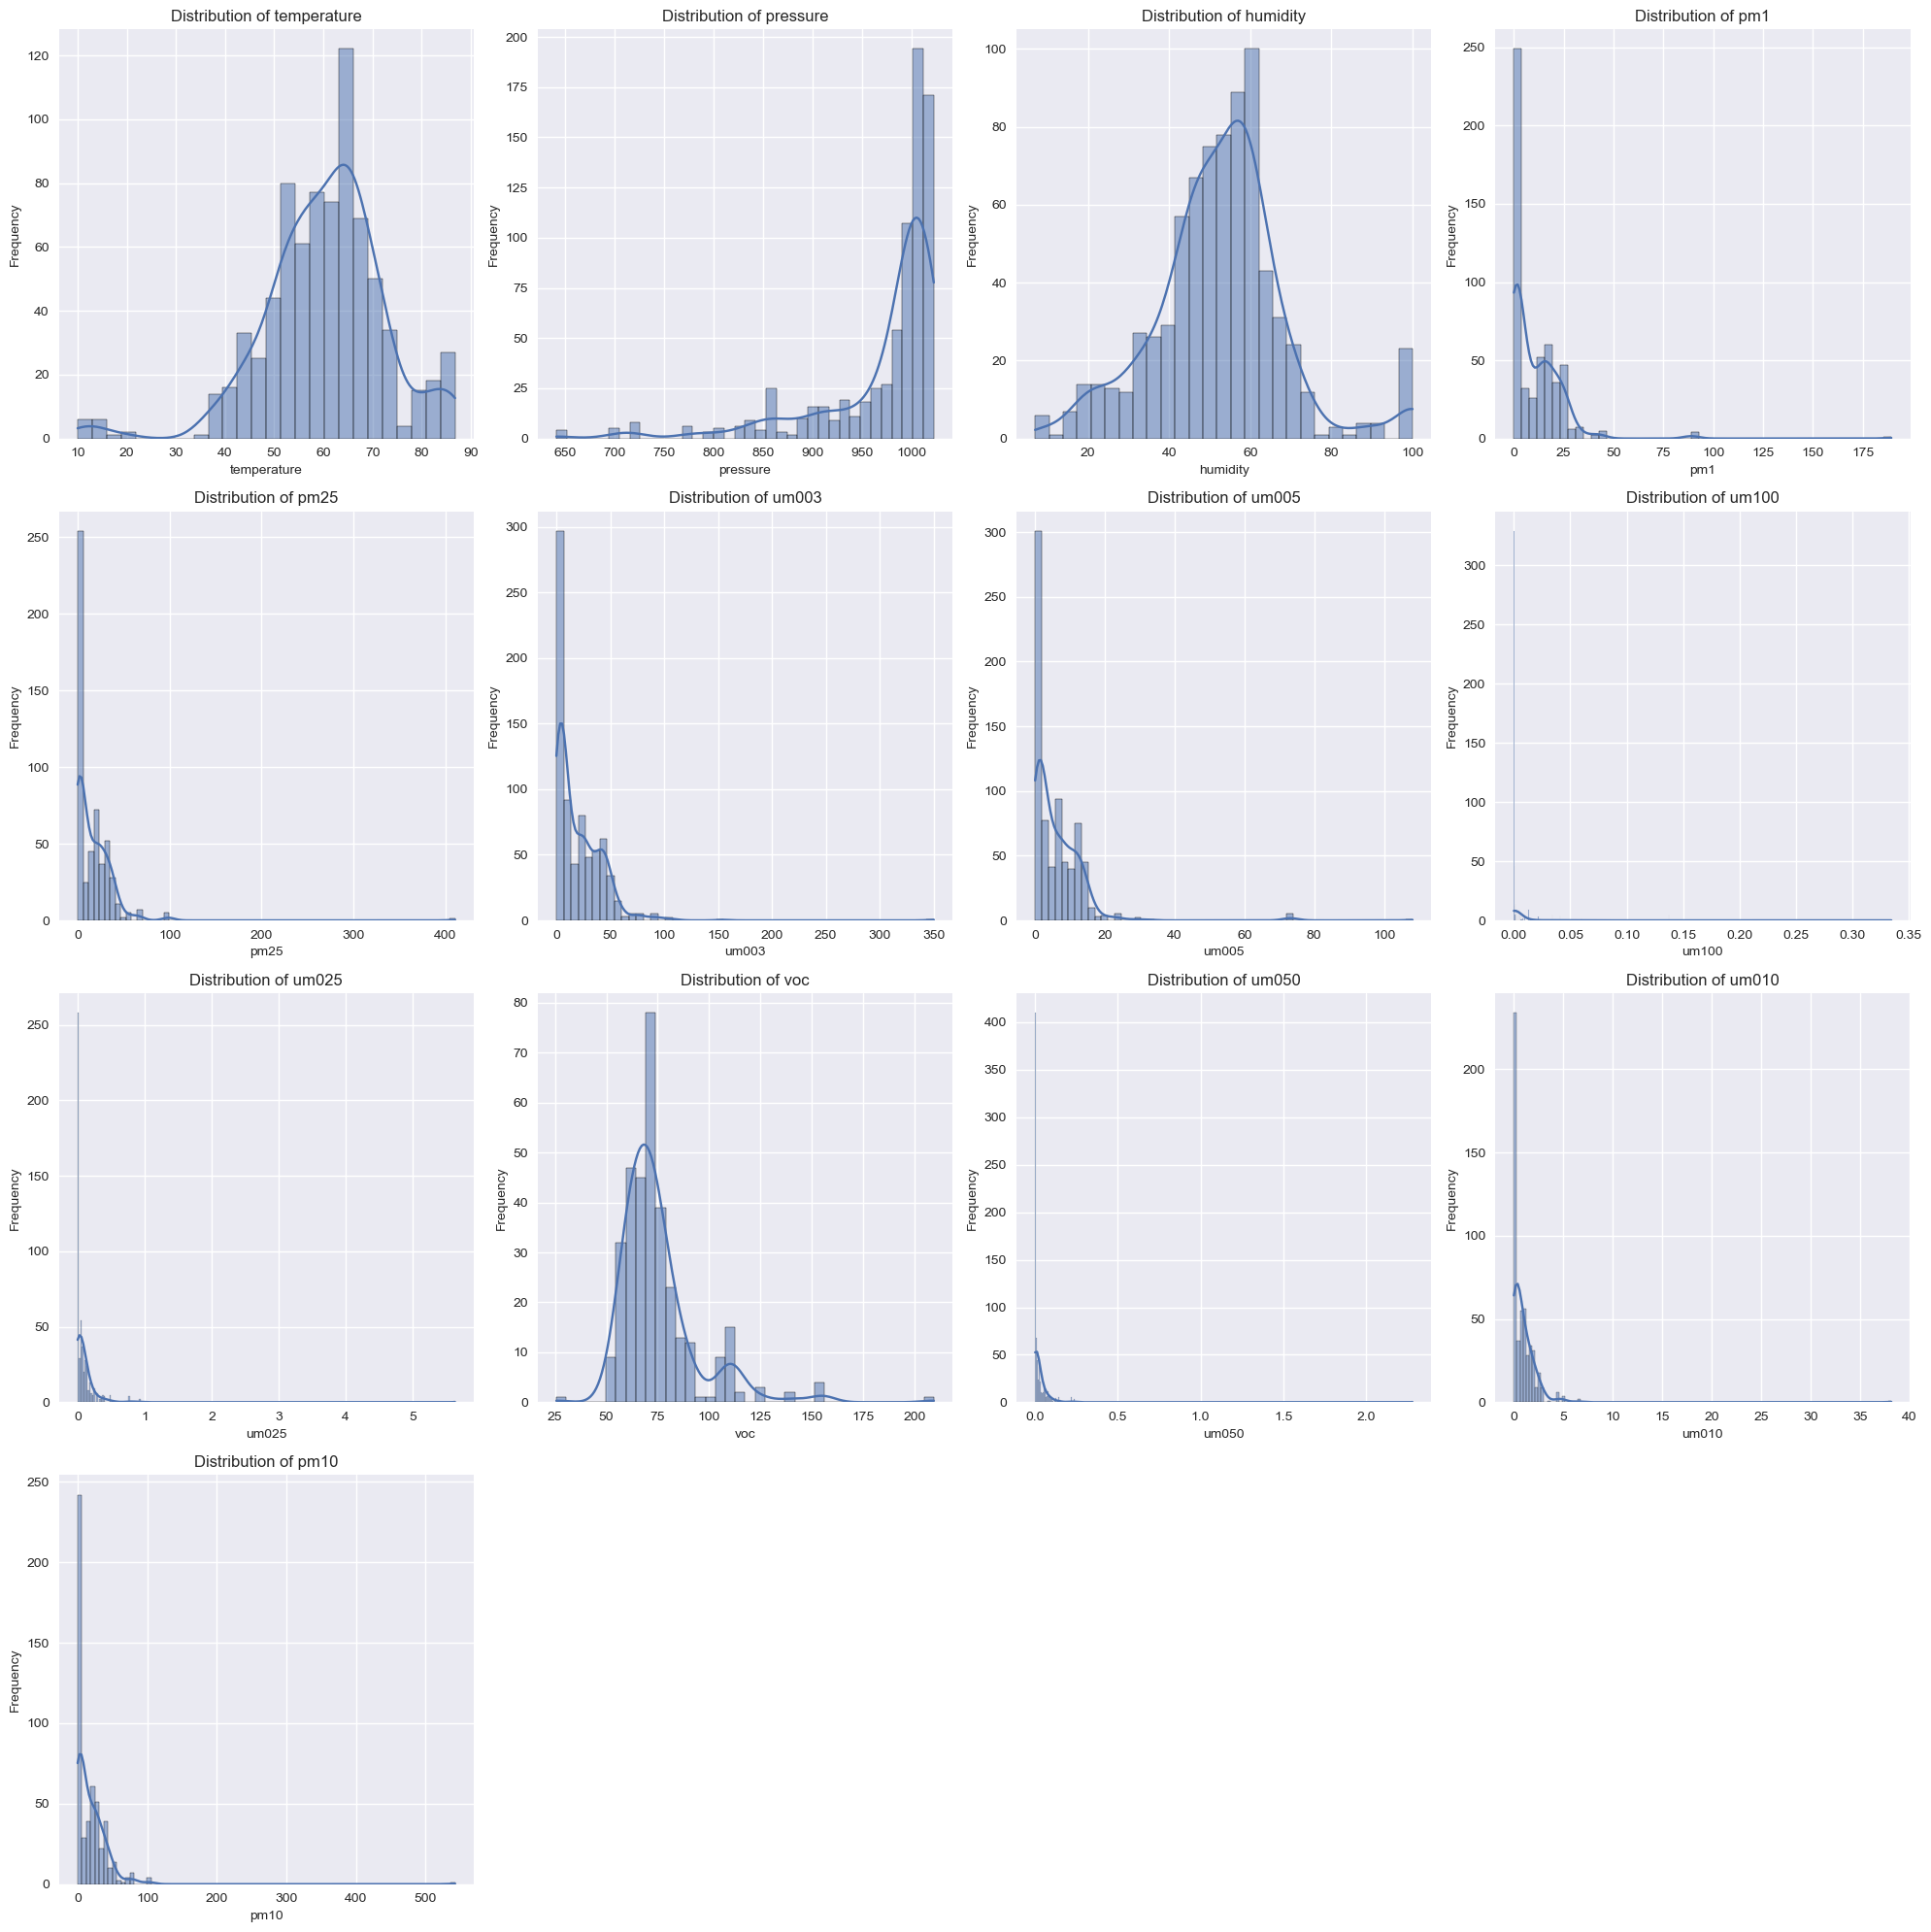

In [11]:
def layout(total_items, max_columns=4):
    """Determine the number of rows and columns for the subplots."""
    columns = min(total_items, max_columns)
    rows = total_items // columns
    rows += total_items % columns > 0
    return rows, columns
all_parameters = air_quality_data['parameter'].unique()
rows, columns = layout(len(all_parameters), max_columns=4)

plt.figure(figsize=(5 * columns, 5 * rows))

for i, param in enumerate(all_parameters, 1):
    plt.subplot(rows, columns, i)
    subset = air_quality_data[air_quality_data['parameter'] == param]
    
    if not subset.empty:
        sns.histplot(subset['value'], kde=True)
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


***
#### Data Quality Checks and Outlier Detection

- Perform basic data quality checks.
- Calculate and display missing values and their percentage in the dataset.
- Detect and visualize outliers for common air pollutants using boxplots.
- Focus on pollutants like PM1, PM2.5, PM10, O3, NO2, SO2, and CO.
***

                   Missing Values  Percentage
city                         8050   100.00000
isAnalysis                   8050   100.00000
capital_worldcity            7783    96.68323


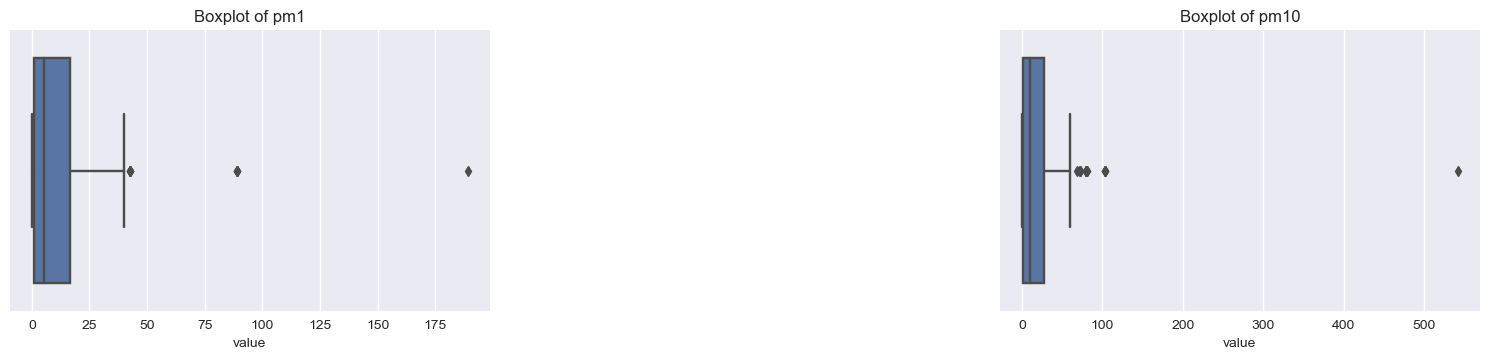

In [12]:
# 1. Check for Missing Values
missing_values = air_quality_data.isnull().sum()
missing_values_percentage = (missing_values / len(air_quality_data)) * 100

# Display missing values and their percentage
missing_values_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percentage})
print(missing_values_summary[missing_values_summary['Missing Values'] > 0])

# 2. Detect Outliers through Boxplots
common_pollutants = ['pm1', 'pm2.5', 'pm10', 'o3', 'no2', 'so2', 'co']

# PLot boxplots for selected common pollutants
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(common_pollutants, 1):
    pollutant_data = air_quality_data[air_quality_data['parameter'] == pollutant]
    
    if not pollutant_data.empty:
        plt.subplot(3, 3, i)
        sns.boxplot(x=pollutant_data['value'])
        plt.title(f'Boxplot of {pollutant}')

plt.tight_layout()
plt.show()


***
#### Correlation Analysis of Air Quality Parameters

- Convert relevant columns to numeric types.
- Calculate correlation and visualize to illustrate the correlations between different pollutants.
***

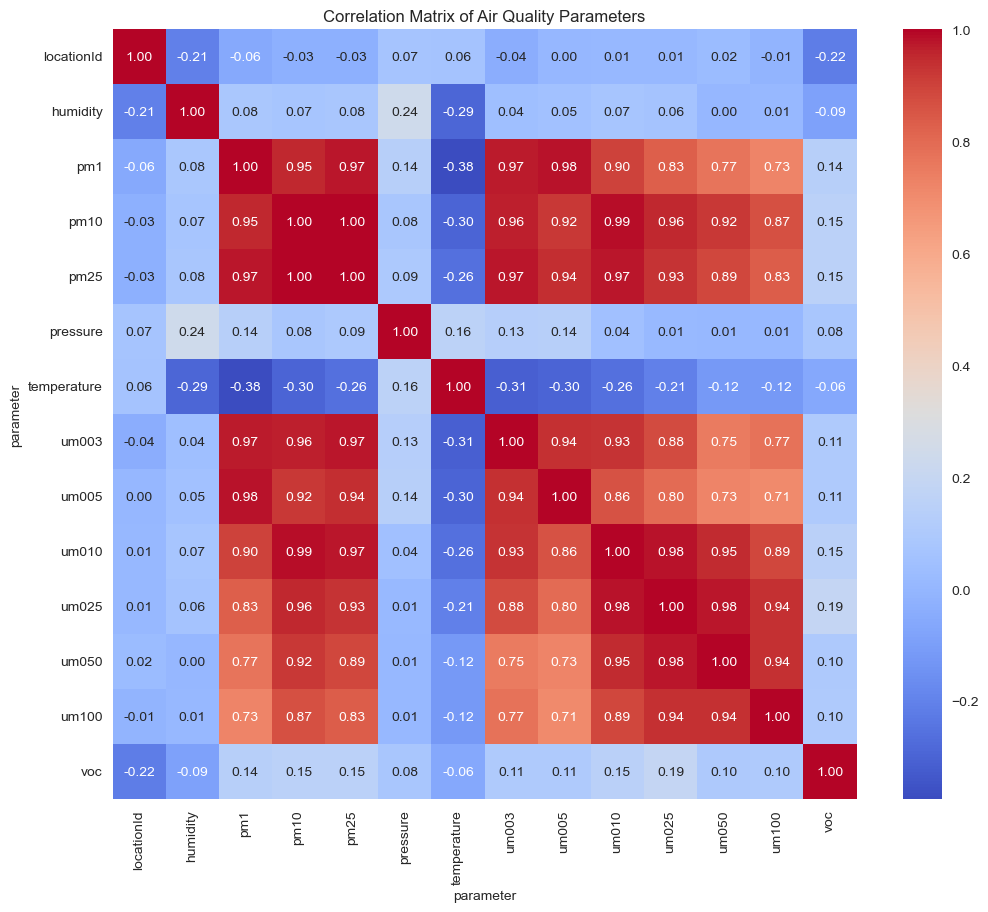

In [13]:
# Convert 'value' column to numeric, coercing errors into NaN
air_quality_data['value'] = pd.to_numeric(air_quality_data['value'], errors='coerce')

# Filter out non-numeric entries
numeric_data = air_quality_data.dropna(subset=['value'])

# Create a pivot table
pivot_data = numeric_data.pivot_table(index=['locationId', 'country', 'new_city'], 
                                      columns='parameter', values='value', aggfunc='mean').reset_index()

# Drop non-numeric columns
pivot_data_numeric = pivot_data.select_dtypes(include=[float, int])

# Calculate and visualize the correlation matrix
correlation_matrix = pivot_data_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Air Quality Parameters')
plt.show()


***
#### Aggregate Analysis for the Parameter 'PM10'

- Aggregate average PM10 values at the city level to understand the distribution of this pollutant geographically.
- Display the top 5 cities with the highest average PM10 values, highlighting areas with significant air quality concerns.
- Filter out unnecessary columns based on previous missing value analysis, retaining only those that are relevant for further analysis or visualization.
***

In [14]:
# Aggregate Analysis for a common parameter 'pm10'
# Aggregating the average 'pm10' values at the city level
pm10_city_aggregate = numeric_data[numeric_data['parameter'] == 'pm10'].groupby('new_city')['value'].mean().sort_values(ascending=False).reset_index()

# Displaying the top 5 cities with the highest average 'pm10' values
pm10_city_aggregate_top5 = pm10_city_aggregate.head(5)
print(pm10_city_aggregate_top5)

# Filtering out unnecessary columns based on the previous missing value analysis
columns_to_keep = ['locationId', 'country', 'new_state', 'new_city', 
                   'population_worldcity', 'parameter', 'value']
filtered_data = air_quality_data[columns_to_keep]

# Checking the first few rows of the filtered dataset to confirm changes
filtered_data.head()


     new_city       value
0   Maryville  542.486207
1     Trenton  102.846429
2  Chowchilla   80.706897
3   Morganton   80.153846
4      Cicero   72.081818


,locationId,country,new_state,new_city,population_worldcity,parameter,value
0,67784,US,California,San Francisco,3290197,temperature,64.625000
1,67784,US,California,San Francisco,3290197,pressure,1002.707500
2,67784,US,California,San Francisco,3290197,humidity,100.000000
3,1794834,US,Utah,West Point,10963,pressure,868.780741
4,1794834,US,Utah,West Point,10963,pm1,14.337037


***
# Data Preprocessing

- **Data Cleaning:** Remove rows with missing values in the 'value' column and convert the 'value' column to numeric, handling non-numeric entries.
- **Outlier Treatment:** For each pollutant parameter, cap the values at the 1st and 99th percentile. This approach helps in managing extreme values which might skew the analysis.
- **Normalization:** Apply Min-Max scaling to the 'value' column. This step is essential for normalizing the range of the data, making it suitable for algorithms that are sensitive to the scale of input features.
- **Data Transformation:** Pivot the table to arrange the data with countries, states, cities, and their populations as rows, and pollutant parameters as columns. This restructured format is more convenient for clustering and other analyses.
- **Handling Missing Values Post-Pivot:** Fill any NaN values that emerge after pivoting with 0. This step ensures that the dataset is complete and ready for further processing.
- **Scaling Pivot Table:** Apply Min-Max scaling to the pivot table, ensuring that the data across different parameters is on a comparable scale.
***

In [15]:
filtered_data = filtered_data.dropna(subset=['value'])
filtered_data['value'] = pd.to_numeric(filtered_data['value'], errors='coerce')

# Get the list of unique pollutants present
available_pollutants = filtered_data['parameter'].unique()

# Outlier Treatment: Cap the values at the 1st and 99th percentile for each available pollutant parameter
for pollutant in available_pollutants:
    lower_bound = filtered_data.loc[filtered_data['parameter'] == pollutant, 'value'].quantile(0.01)
    upper_bound = filtered_data.loc[filtered_data['parameter'] == pollutant, 'value'].quantile(0.99)
    filtered_data.loc[filtered_data['parameter'] == pollutant, 'value'] = np.clip(filtered_data.loc[filtered_data['parameter'] == pollutant, 'value'], lower_bound, upper_bound)

# Normalization: Apply Min-Max scaling to the 'value' column
scaler = MinMaxScaler()
filtered_data['value_scaled'] = scaler.fit_transform(filtered_data[['value']])

# Pivot the table for clustering
pivot_data_preprocessed = filtered_data.pivot_table(
    index=['country', 'new_state', 'new_city', 'population_worldcity'], 
    columns='parameter', 
    values='value_scaled', 
    aggfunc='mean'
)

# Fill any remaining NaN values with 0 after pivot
pivot_data_preprocessed.fillna(0, inplace=True)

# Scale the pivot table
pivot_data_scaled = scaler.fit_transform(pivot_data_preprocessed)


***
<a id='Machine-Learning-Clustering-Analysis'></a>
# Machine Learning: Clustering Analysis

- **Function `fit_clustering_models`:** This function is designed to fit different clustering models to the data and evaluate them. It takes scaled and preprocessed data as input, along with the number of clusters for KMeans and Hierarchical Clustering.

- **Supported Models:**
  - **KMeans:** A popular centroid-based clustering algorithm.
  - **Hierarchical Clustering:** A method of cluster analysis which seeks to build a hierarchy of clusters.
  - **DBSCAN:** A density-based clustering algorithm.

- **Evaluation Metrics:**
  - **Silhouette Score:** Measures how similar an object is to its own cluster compared to other clusters.
  - **Davies-Bouldin Score:** Evaluates intra-cluster similarity and inter-cluster differences.
  - **Calinski-Harabasz Score:** Measures the cluster validity based on cluster dispersion.

- **Execution and Results:**
  - The function is called with the scaled dataset and a specified number of clusters.
  - It outputs the fitted models and their evaluation metrics.
  - Special handling is included for DBSCAN, which may result in a single cluster or outliers, affecting the validity of some scores.

- **KMeans Labels Extraction:** Extracts the cluster labels from the KMeans model's results for further analysis.
***

In [29]:
def fit_clustering_models(data, n_clusters):
    models = {
        'KMeans': KMeans(n_clusters=n_clusters, random_state=1),
        'Hierarchical': AgglomerativeClustering(n_clusters=n_clusters),
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5)  
    }
    
    metrics = {
        'Silhouette Score': silhouette_score,
        'Davies-Bouldin Score': davies_bouldin_score,
        'Calinski-Harabasz Score': calinski_harabasz_score
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Fit the model
        model_labels = model.fit_predict(data)
        results[model_name] = {'model': model, 'labels': model_labels}
        
        # Compute evaluation metrics only if there are at least 2 clusters (excluding noise)
        if len(set(model_labels)) - (1 if -1 in model_labels else 0) > 1:
            for metric_name, metric in metrics.items():
                try:
                    score = metric(data, model_labels)
                    results[model_name][metric_name] = score
                except ValueError:
                    results[model_name][metric_name] = None
    
    return results


# Fit the models and get the results
n_clusters = 3
clustering_results = fit_clustering_models(pivot_data_scaled, n_clusters)

# Output the results
for model_name, results in clustering_results.items():
    print(f"Results for {model_name}:")
    for metric, value in results.items():
        if metric != 'model' and metric != 'labels':
            # Only print the scores if they were computed
            if value is not None:
                print(f"  {metric}: {value}")
    print("\n")

kmeans_labels = clustering_results['KMeans']['labels']


Results for KMeans:
  Silhouette Score: 0.42341978866501573
  Davies-Bouldin Score: 0.85494731211308
  Calinski-Harabasz Score: 104.52295700448418


Results for Hierarchical:
  Silhouette Score: 0.39786364472186947
  Davies-Bouldin Score: 0.8965622820042564
  Calinski-Harabasz Score: 97.302445509236


Results for DBSCAN:
  Silhouette Score: 0.4415271022585206
  Davies-Bouldin Score: 1.4882194743128976
  Calinski-Harabasz Score: 39.40940785138864




***
# Insights and Interpretation of Clustering Results

The clustering models yield different results, each providing unique insights:

- **KMeans Results:**
  - *Silhouette Score (0.42):* Indicates moderate separation between clusters. The value suggests that the clusters are not highly distinct but reasonably well-defined.
  - *Davies-Bouldin Score (0.85):* A lower score is better. This score suggests that the clusters are moderately well-separated and compact.
  - *Calinski-Harabasz Score (104.52):* A higher score indicates better-defined clusters. This score suggests that the clusters are relatively well-separated.

- **Hierarchical Clustering Results:**
  - *Silhouette Score (0.40):* Similar to KMeans, indicating moderate separation between clusters.
  - *Davies-Bouldin Score (0.90):* Slightly higher than KMeans, indicating less separation and compactness in the clusters.
  - *Calinski-Harabasz Score (97.30):* Slightly lower than KMeans, suggesting that the clusters are not as well-defined.

- **DBSCAN Results:**
  - *Silhouette Score (0.44):* The highest among the three, suggesting the best separation between clusters. However, DBSCAN's tendency to form a varying number of clusters based on density should be considered.
  - *Davies-Bouldin Score (1.49):* The highest score, indicating less optimal clustering in terms of separation and compactness.
  - *Calinski-Harabasz Score (39.41):* Significantly lower, indicating that the clusters are less distinct and well-separated compared to KMeans and Hierarchical.

### Overall Insights:
- KMeans and Hierarchical Clustering perform similarly, with KMeans slightly outperforming in terms of cluster definition and separation.
- DBSCAN shows the best potential for cluster separation but also indicates less compact and well-defined clusters. This might be due to its density-based clustering nature, which can create clusters of varying densities and sizes.
- The choice of model should depend on the specific requirements of the analysis and the characteristics of the dataset. KMeans provides a good balance of separation and definition, making it suitable for many general clustering needs.
***

In [19]:
# Extracting the cluster centroids
centroids = clustering_results['KMeans']['model'].cluster_centers_
print("Cluster Centroids:\n", centroids)

# Counting the number of data points in each cluster
cluster_counts = pd.Series(clustering_results['KMeans']['labels']).value_counts().sort_index()
print("\nCluster Composition:\n")
print(cluster_counts)

# Reset index of pivot_data_preprocessed if indices are mismatched
pivot_data_preprocessed_reset = pivot_data_preprocessed.reset_index()
pivot_data_preprocessed_reset['Cluster'] = kmeans_labels

# Calculate the mean values for each cluster
numeric_cols = pivot_data_preprocessed_reset.select_dtypes(include=[np.number])
numeric_cols['Cluster'] = pivot_data_preprocessed_reset['Cluster']
cluster_means = numeric_cols.groupby('Cluster').mean()
print("\nMean Values:\n", cluster_means)


Cluster Centroids:
 [[ 5.28608914e-01  4.80282680e-02  4.45035461e-02  3.58604878e-02
   9.27003338e-01  7.23300635e-01  9.95200729e-02  9.29358073e-02
   3.49287228e-02  1.61148695e-02  3.27346793e-02  2.40852299e-03
   1.97185308e-01]
 [ 5.00417595e-01  5.00865227e-01  4.58794396e-01  3.85284450e-01
   9.52699596e-01  6.36520353e-01  4.36673390e-01  3.95634517e-01
   3.76926411e-01  2.24075557e-01  1.57731321e-01  7.12870770e-02
   1.94942006e-01]
 [-5.55111512e-17  8.71564160e-04  1.19848730e-03  9.77162205e-02
  -1.11022302e-16  6.92032189e-02  5.05416212e-02  5.84894310e-02
   1.18874710e-03  1.14335606e-04  8.16721633e-03  0.00000000e+00
   0.00000000e+00]]

Cluster Composition:

0    131
1     64
2     12
Name: count, dtype: int64

Mean Values:
 parameter  population_worldcity  humidity       pm1      pm10      pm25  \
Cluster                                                                   
0                 176628.916031  0.051767  0.002008  0.003517  0.002981   
1           


***
### Insights from KMeans Clustering Analysis

- **Cluster Centroids:**
  - *Cluster 0 Centroid:* Shows moderate values across most parameters, indicating a balanced profile of air quality factors.
  - *Cluster 1 Centroid:* Characterized by higher values in PM1, PM10, and PM25, suggesting higher levels of particulate matter and potential air pollution issues.
  - *Cluster 2 Centroid:* Near-zero values for most parameters, possibly representing locations with sparse data or exceptionally clean air.

- **Cluster Composition:**
  - *Cluster 0:* The largest group with 131 data points, possibly representing the most common air quality profile across the sampled locations.
  - *Cluster 1:* Contains 64 data points, likely areas with more pronounced air quality concerns.
  - *Cluster 2:* The smallest group with 12 data points, indicating either outliers or unique conditions not widely represented in the dataset.

- **Mean Values Analysis:**
  - *Cluster 0:* Shows lower average values for PM1, PM10, and PM25, suggesting better air quality conditions.
  - *Cluster 1:* Exhibits higher averages in particulate matter, indicating regions with potential air pollution challenges.
  - *Cluster 2:* Demonstrates negligible mean values for most pollutants, aligning with its centroid profile as potentially representing areas with minimal pollution or lacking data.

### Overall Interpretation:
- The clusters formed by the KMeans algorithm reveal distinct profiles of air quality conditions across different locations.
- Clusters 0 and 1 differentiate between areas with moderate to higher levels of air pollution, respectively, while Cluster 2 might represent either exceptionally clean areas or data sparsity.
- These insights can guide targeted environmental policies and interventions, focusing resources on areas identified as having higher pollution levels (Cluster 1).
***

*** 
# Preprocessing for User-Interactive Visualization

- **Unique Key Generation:**
  - Create a 'unique_key' in the original air quality dataset by concatenating 'country', 'new_state', and 'new_city'. This unique key assists in merging datasets while maintaining location specificity.
  - Similarly, generate the 'unique_key' in the clustered dataset (`pivot_data_preprocessed_reset`).

- **Merging Datasets:**
  - Perform a left join on `air_quality_data` and `pivot_data_preprocessed_reset` using the 'unique_key', merging the cluster information with the original dataset.
  - After merging, the 'unique_key' column is dropped as it's no longer needed.

- **Preparing Data for Geographical Visualization:**
  - Create a wide-format table (`wide_data`) from the merged dataset using a pivot operation. This table includes location IDs, geographic coordinates, and the cluster each location belongs to, alongside average pollution values for each parameter.
  - This wide-format dataset is now ready for creating user-interactive geographical visualizations.
***

In [28]:
# Create a unique key in the original dataset
air_quality_data['unique_key'] = air_quality_data['country'] + '_' + air_quality_data['new_state'] + '_' + air_quality_data['new_city']

# Create the same key in the clustered dataset
pivot_data_preprocessed_reset['unique_key'] = pivot_data_preprocessed_reset['country'] + '_' + pivot_data_preprocessed_reset['new_state'] + '_' + pivot_data_preprocessed_reset['new_city']

# Perform a left join to merge the datasets
merged_data = pd.merge(air_quality_data, pivot_data_preprocessed_reset[['unique_key', 'Cluster']], on='unique_key', how='left')
merged_data.drop('unique_key', axis=1, inplace=True)
print(merged_data.head())

wide_data = merged_data.pivot_table(
    index=['locationId', 'country', 'new_state', 'new_city', 'lat_worldcity', 'lng_worldcity', 'Cluster'],
    columns='parameter',
    values='value',
    aggfunc='mean'
).reset_index()


   locationId               location    parameter        value   unit country  \
0       67784            Diamond St.  temperature    64.625000      f      US   
1       67784            Diamond St.     pressure  1002.707500     mb      US   
2       67784            Diamond St.     humidity   100.000000      %      US   
3     1794834  West Point Elementary     pressure   868.780741     mb      US   
4     1794834  West Point Elementary          pm1    14.337037  µg/m³      US   

   city  isMobile  isAnalysis                  entity  ... lat_worldcity  \
0   NaN     False         NaN  Community Organization  ...       37.7558   
1   NaN     False         NaN  Community Organization  ...       37.7558   
2   NaN     False         NaN  Community Organization  ...       37.7558   
3   NaN     False         NaN                  Person  ...       41.1220   
4   NaN     False         NaN                  Person  ...       41.1220   

  lng_worldcity country_worldcity  iso2_worldcity  iso3_

***
<a id='User-Interactive-Visualization-Air-Quality-Map'></a>
# User-Interactive Visualization: Air Quality Map

- **Threshold Calculation Functions:**
  - `calculate_thresholds`: Computes dynamic thresholds for air quality parameters based on their 33rd and 66th percentiles, aiding in categorizing the levels of pollution.
  - `classify_level`: Classifies the level of a given parameter (like PM2.5, PM10, CO, temperature, and humidity) based on the calculated thresholds.

- **Dynamic Threshold Calculation:** 
  - Calculate thresholds for PM2.5, PM10, CO, temperature, and humidity using the `calculate_thresholds` function.

- **Map Initialization with Folium:**
  - Initialize a base map centered on the United States using Folium, setting an appropriate zoom level.

- **Marker Cluster Initialization:**
  - Implement a MarkerCluster to manage and group the location markers on the map, enhancing readability and usability.

- **Color Assignment Function:**
  - Define `get_color`, a function to assign colors to markers based on their cluster classification.

- **Populating the Map with Data:**
  - Iterate through the dataset (`wide_data`), classifying the level of each parameter for every location.
  - For each location, create a circle marker with a color indicative of its cluster. Include a popup displaying detailed information about air quality parameters, formatted with HTML for clarity.

- **Saving the Interactive Map:**
  - Save the completed interactive map as an HTML file, enabling easy access and sharing.

This interactive map provides a comprehensive and user-friendly way to visualize air quality data across different locations, highlighting pollution levels and other environmental factors.
***

In [35]:
# Function to calculate dynamic thresholds based on 33rd and 66th percentiles
def calculate_thresholds(data, parameter):
    if parameter in data.columns:
        medium_threshold = data[parameter].quantile(0.33)
        high_threshold = data[parameter].quantile(0.66)
        return {'medium': medium_threshold, 'high': high_threshold}
    else:
        return None

# Function to classify pollution, temperature, and humidity levels
def classify_level(value, thresholds):
    if pd.isna(value) or thresholds is None:
        return "N/A"
    elif value > thresholds['high']:
        return "High"
    elif value > thresholds['medium']:
        return "Medium"
    else:
        return "Low"

# Calculating thresholds
pm25_thresholds = calculate_thresholds(wide_data, 'pm25')
pm10_thresholds = calculate_thresholds(wide_data, 'pm10')
co_thresholds = calculate_thresholds(wide_data, 'co')
temperature_thresholds = calculate_thresholds(wide_data, 'temperature')
humidity_thresholds = calculate_thresholds(wide_data, 'humidity')

# Create a base map centered on the US
map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Initialize MarkerCluster
marker_cluster = MarkerCluster().add_to(map)

# Function to choose color based on cluster
def get_color(cluster):
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    return colors[cluster % len(colors)]

# Add points to the map
for _, row in wide_data.iterrows():
    pollution_pm25 = classify_level(row.get('pm25'), pm25_thresholds)
    pollution_pm10 = classify_level(row.get('pm10'), pm10_thresholds)
    pollution_co = classify_level(row.get('co'), co_thresholds)
    temperature_level = classify_level(row.get('temperature'), temperature_thresholds)
    humidity_level = classify_level(row.get('humidity'), humidity_thresholds)

    # Popup content with HTML Styling
    popup_content = f"""
    <div style='font-size: 14px;'>
    <strong>City:</strong> {row['new_city']}<br>
    <strong>State:</strong> {row['new_state']}<br>
    <strong>Cluster:</strong> {row['Cluster']}<br>
    <ul>
        <li>PM2.5 Level: {pollution_pm25}</li>
        <li>PM10 Level: {pollution_pm10}</li>
        <li>CO Level: {pollution_co}</li>
        <li>Temperature Level: {temperature_level}</li>
        <li>Humidity Level: {humidity_level}</li>
    </ul>
    </div>
    """

    folium.CircleMarker(
        location=(row['lat_worldcity'], row['lng_worldcity']),
        radius=8,  
        color=get_color(row['Cluster']),
        fill=True,
        fill_color=get_color(row['Cluster']),
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(marker_cluster)

# Save the map to an HTML file
map.save("air_quality_analysis.html")

file_path = "air_quality_analysis.html"
IFrame(src=file_path, width=700, height=500)
